In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4
from scipy.interpolate import griddata

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
alongtrack_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/')
grids_file_dir = Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/')
main_dir = Path('/home/jovyan/ECCO_GMSL/')
output_dir = Path('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/')
output_dir2 = Path('/home/jovyan/Data/ECCO_GMSL/GMSL/')

### 3 errors: Random noise + missing data + orbit error - 2cm

#### Making 1x3 grids every 10 days

In [3]:
ECCO_alongtrack_files = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_1992-09-23_3errors.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_1992-09-24_3errors.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_1992-09-25_3errors.nc')
 ...
 PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2017-12-29_3errors.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2017-12-30_3errors.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2017-12-31_3errors.nc')]


In [4]:
latgrid=np.arange(-90,90,1)
longrid=np.arange(-180,180,3)
[LOgrid,LAgrid] = np.meshgrid(longrid,latgrid)

In [5]:
len(ECCO_alongtrack_files)

9231

In [6]:
f=4240
ECCO_alongtrack_files[f:f+10]

array([PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-03_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-04_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-05_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-06_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-07_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-08_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/ECCO_V4r4_alongtrack_output_3errors_2cm/ECCO_V4r4_alongtrack_SSH_2004-05-09_3errors.nc'),
       PosixPath('/home/jovyan/Data/ECCO_GMSL/EC

In [7]:
# for f in np.arange(0,len(ECCO_alongtrack_files),10):
#     grids=[]
#     ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[f:f+10]
#     alongtrack = xr.open_mfdataset(
#             paths=ECCO_alongtrack_files_cycle,
#             combine='nested',
#             concat_dim='i',
#             decode_cf=True,
#             compat='override',
#             coords='minimal',
#             chunks={'time': 1}  
#         )  
#     SSH_at_xy_ano=alongtrack.SSH_at_xy
#     ind=np.where(np.isfinite(SSH_at_xy_ano.values))
#     x=SSH_at_xy_ano.lon.values[ind]
#     y=SSH_at_xy_ano.lat.values[ind]
#     data=SSH_at_xy_ano.values[ind]

#     datagrid = np.empty((len(latgrid),len(longrid)))
#     ngrid = np.empty((len(latgrid),len(longrid)))
#     datagridrms = np.empty((len(latgrid),len(longrid)))
#     datagridstd = np.empty((len(latgrid),len(longrid)))
#     datagrid[:] = np.nan
#     ngrid[:] = np.nan
#     datagridrms[:] = np.nan
#     datagridstd[:] = np.nan
#     resx = float(longrid[1]-longrid[0]) 
#     resy = float(latgrid[1]-latgrid[0])     
#     for i in range(0,len(longrid)):
#         for j in range(0,len(latgrid)):
#             ind = np.where((abs(longrid[i]-x)<=resx/2) & (abs(latgrid[j]-y)<=resy/2) & (np.isfinite(data)))
#             if len(ind[0])>0:
#                 datagrid[j,i] = np.nanmean(data[ind],axis=0)
#                 datagridrms[j,i] = np.sqrt(np.nansum(data[ind]**2,axis=0)/len(ind[0]))
#                 datagridstd[j,i] = np.nanstd(data[ind],axis=0)
#                 ngrid[j,i] = len(ind[0])
#     data_vars = {'SSHA':(['lat','lon'], datagrid, {'units': 'm'}),
#                  'count':(['lat','lon'], ngrid, {'long_name':'nb along track point in each 1x3 grids cell'})}
#     coords = {'lat': (['lat'], latgrid),'lon': (['lon'], longrid), 'time':SSH_at_xy_ano.time.values + np.timedelta64(4, 'D')}
#     attrs = {'author':'Severine Fournier'}
#     grids = xr.Dataset(data_vars=data_vars,coords=coords,attrs=attrs)
#     fname = output_dir / ('SSHA_gridded_3x1_'+str(grids.time.values)[:10]+'.nc')
#     grids.to_netcdf(fname)

In [8]:
# fig = plt.figure(figsize=(15,5))
# cm = plt.get_cmap('gist_rainbow')
# ax=fig.gca()

# ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
# ax.gridlines()
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)

# p=ax.pcolor(longrid,latgrid,datagrid,transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
# h=plt.colorbar(p)

In [9]:
# fig = plt.figure(figsize=(15,5))
# cm = plt.get_cmap('gist_rainbow')
# ax=fig.gca()

# ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
# ax.gridlines()
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)

# p=ax.pcolor(longrid,latgrid,ngrid,transform=ccrs.PlateCarree(),vmin=0,vmax=100, cmap='jet')
# h=plt.colorbar(p)

#### Computing GMSL from these 3x1 grids, simple weights

In [7]:
grids_files = list(output_dir.glob('SSHA_*nc'))
grids_files=np.sort(grids_files)
print(grids_files[0:5])
print('...')
print(grids_files[-5:])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3

In [8]:
grids = xr.open_mfdataset(
        paths=grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:  (time: 924, lat: 180, lon: 120)
Coordinates:
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 165 168 171 174 177
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA     (time, lat, lon) float64 dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    count    (time, lat, lon) float64 dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes:
    author:   Severine Fournier

In [11]:
grids=grids.sel(lat=slice(-66,66))
grids=grids.where(grids.count()>=2)

In [12]:
[LO,LA]=np.meshgrid(grids.lon,grids.lat)
dlat=np.deg2rad(np.abs(grids.lat[1]-grids.lat[0])).values #dlon and dlat are not always constant, if irregular grid for example, not the case here
dlon=np.deg2rad(np.abs(grids.lon[1]-grids.lon[0])).values
area_pixel_rad = np.cos(np.deg2rad(LA)) * dlon*(111/6371) * dlat*(111/6371)
area_pixel_rad=np.tile(area_pixel_rad, [grids.SSHA.shape[0], 1, 1])
area_pixel_rad[np.where(~np.isfinite(grids.SSHA))]=np.nan
area_total_rad = np.nansum(area_pixel_rad,axis=(1,2))

In [13]:
ssh_weighted_mean=np.nansum(grids.SSHA*area_pixel_rad,axis=(1,2))/area_total_rad

/tmp/ipykernel_105/1124743026.py:1: RuntimeWarning: invalid value encountered in divide
  ssh_weighted_mean=np.nansum(grids.SSHA*area_pixel_rad,axis=(1,2))/area_total_rad


In [14]:
gmsl_grids = xr.DataArray(ssh_weighted_mean, dims=['time'])
gmsl_grids = gmsl_grids.assign_coords({'time':grids.time.data})
gmsl_grids.name = 'gmsl_grids_3x1'
gmsl_grids

<xarray.DataArray 'gmsl_grids_3x1' (time: 924)>
array([-3.40280578e-02, -3.21532830e-02, -3.00089647e-02, -3.09492019e-02,
       -3.15737694e-02, -3.44005936e-02, -3.19034724e-02, -3.37054032e-02,
       -3.34708584e-02, -3.93223083e-02, -4.07774414e-02, -4.04029110e-02,
       -4.10211781e-02, -4.25261788e-02, -4.26152426e-02, -4.12557710e-02,
       -4.02519914e-02, -3.82522661e-02, -4.07334783e-02, -3.90091729e-02,
       -3.82552707e-02, -3.81306377e-02, -3.82689877e-02, -4.02486307e-02,
       -3.76574090e-02, -3.70063326e-02, -3.87087127e-02, -3.73906441e-02,
       -3.98846492e-02, -3.78849839e-02, -3.47920755e-02, -3.73534334e-02,
       -3.55441541e-02, -3.42047014e-02, -3.17262547e-02, -3.28502497e-02,
       -3.11460854e-02, -2.86677701e-02, -2.78073320e-02, -2.76712379e-02,
       -3.05511390e-02, -3.08371011e-02, -3.29980182e-02, -3.20801695e-02,
       -2.88029291e-02, -2.69436593e-02, -3.15615333e-02, -3.28087692e-02,
       -3.04538519e-02, -3.40546538e-02, -3.83520354e-02, -4.05648654e-02,
       -3.60240155e-02, -3.32366747e-02, -3.26152558e-02, -3.36907022e-02,
       -3.20740905e-02, -3.41545281e-02, -3.38410526e-02, -3.73853323e-02,
       -3.68240305e-02, -3.72420445e-02, -3.92167753e-02, -4.06736806e-02,
       -4.16574665e-02, -4.00679524e-02, -3.76224890e-02, -3.80376152e-02,
       -3.66175553e-02, -3.58933396e-02, -3.23409936e-02, -3.20764347e-02,
       -3.05027930e-02, -3.08611155e-02, -2.78035925e-02, -2.88798719e-02,
       -2.61012574e-02, -2.71707586e-02, -2.92552521e-02, -2.92892300e-02,
...
        4.82646620e-02,  4.66440948e-02,  4.84235800e-02,  4.54779750e-02,
        4.40266424e-02,  3.99699389e-02,  3.78330512e-02,  4.11701052e-02,
        4.07430519e-02,  3.70317259e-02,  3.78443974e-02,  3.53117396e-02,
        3.73087395e-02,  3.50687700e-02,  3.83683019e-02,  3.64032668e-02,
        3.76770233e-02,  3.68593492e-02,  3.96112798e-02,  3.86267082e-02,
        3.78161700e-02,  3.89694679e-02,  3.81660395e-02,  3.85949957e-02,
        3.89321446e-02,  3.70103555e-02,  3.67104444e-02,  3.91695246e-02,
        3.98067217e-02,  4.10002759e-02,  4.48233761e-02,  4.56666252e-02,
        4.29752394e-02,  4.35057640e-02,  4.58422345e-02,  4.72964983e-02,
        4.72886684e-02,  4.82801747e-02,  4.78042489e-02,  4.87712021e-02,
        4.64770115e-02,  4.67632218e-02,  4.53853676e-02,  4.48859173e-02,
        4.20837793e-02,  3.90396578e-02,  3.61551988e-02,  3.79403240e-02,
        3.68223524e-02,  3.68252286e-02,  3.82463142e-02,  3.74332520e-02,
        3.86076821e-02,  4.01360945e-02,  4.17464874e-02,  4.21517211e-02,
        4.01498613e-02,  3.98686195e-02,  4.30399425e-02,  4.15866903e-02,
        4.16362203e-02,  4.01423502e-02,  4.13840498e-02,  4.40598039e-02,
        4.47559517e-02,  4.73046229e-02,  4.78457297e-02,  4.88958869e-02,
        5.08480613e-02,  4.85085251e-02,  4.98076828e-02,  4.98442713e-02,
        5.33380940e-02,  5.47183950e-02,  5.47246772e-02,  5.64854284e-02,
        5.56960943e-02,  5.65223367e-02,  5.28524074e-02,  5.35266441e-02])
Coordinates:
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

In [15]:
fname = output_dir2 / ('GMSL_grids_3x1_3errors_2cm.nc')
gmsl_grids.to_netcdf(fname)

# TEST

### Spatial trends of grids-grids 3x1

In [16]:
grids_files = list(grids_file_dir.glob('*SSHA_gridded_*nc'))
grids_files=np.sort(grids_files)
print(grids_files[0:5])
print('...')
print(grids_files[-5:])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_2017-12-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/SSHA_gridded_2018-01-04.nc')]


In [17]:
grids = xr.open_mfdataset(
        paths=grids_files,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 923)
Coordinates:
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    counts     (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    mask       (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    gridding_method:  Gridded using pyresample resample_gauss with roi=600000...

In [18]:
[LO,LA]=np.meshgrid(grids.longitude,grids.latitude)
[LOgrid,LAgrid]=np.meshgrid(longrid,latgrid)
LOgrid = np.reshape(LOgrid,np.prod(LOgrid.shape))
LAgrid = np.reshape(LAgrid,np.prod(LAgrid.shape))
LO = np.reshape(LO,np.prod(LO.shape))
LA = np.reshape(LA,np.prod(LA.shape))
grids_regrid=[]
for i in range(0,grids.SSHA.shape[0]):
    data = np.reshape(grids.SSHA[i,:,:].values,np.prod(grids.SSHA[i,:,:].shape))
    grids_regrid_tmp = griddata((LO,LA), data, (LOgrid, LAgrid), method='nearest')
    grids_regrid_tmp = np.reshape(grids_regrid_tmp,(1,len(latgrid),len(longrid)))
    try:
        grids_regrid=np.vstack((grids_regrid,grids_regrid_tmp))
    except:
        grids_regrid=grids_regrid_tmp

In [19]:
grids_regrid = xr.DataArray(grids_regrid, dims=['time','lat','lon'])
grids_regrid = grids_regrid.assign_coords({'lon':longrid,'lat':latgrid})
grids_regrid.name = 'SSHA'
grids_regrid.attrs['units'] = 'm'
grids_regrid['time']=grids.time
grids_regrid

<xarray.DataArray 'SSHA' (time: 923, lat: 180, lon: 120)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 165 168 171 174 177
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m

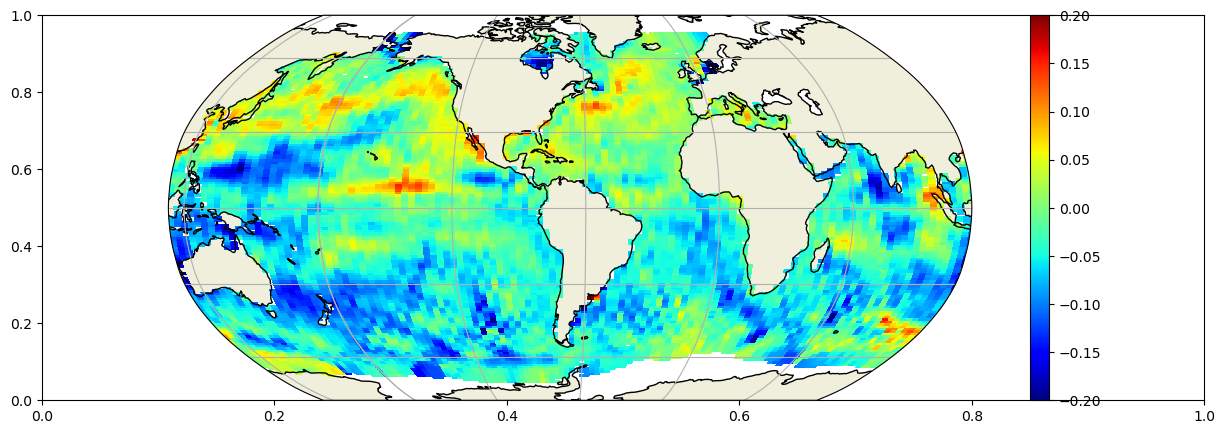

In [20]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(longrid,latgrid,grids_regrid[1,:,:].squeeze(),transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)

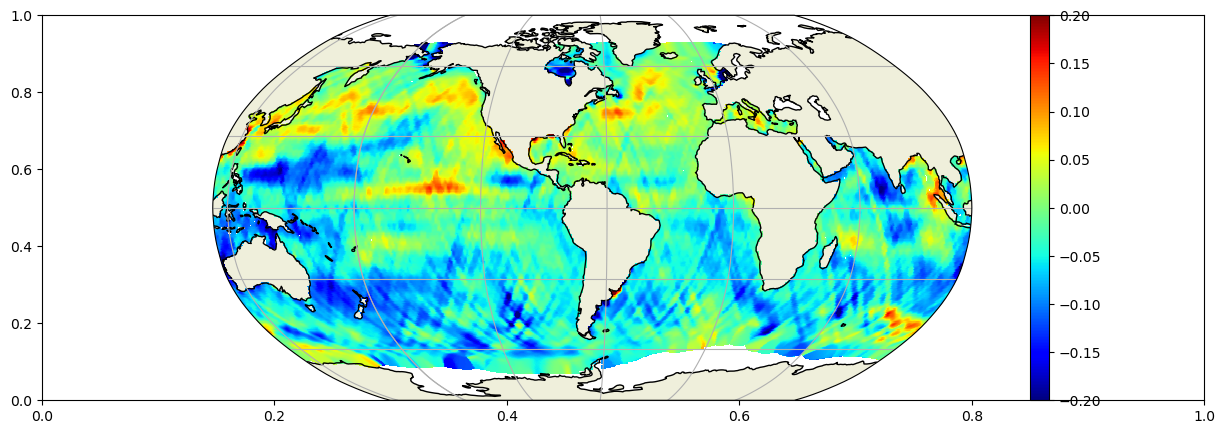

In [21]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(grids.longitude,grids.latitude,grids.SSHA[1,:,:].squeeze(),transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)

In [22]:
grids_files_3x1 = list(output_dir.glob('*SSHA_gridded_3x1_*nc'))
grids_files_3x1=np.sort(grids_files_3x1)
print(grids_files_3x1[0:5])
print('...')
print(grids_files_3x1[-5:])

[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-09-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-07.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-17.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-10-27.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_1992-11-06.nc')]
...
[PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-11-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-05.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-15.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3x1_output_3errors_2cm/SSHA_gridded_3x1_2017-12-25.nc')
 PosixPath('/home/jovyan/Data/ECCO_GMSL/gridding_3

In [23]:
grids_3x1 = xr.open_mfdataset(
        paths=grids_files_3x1,
        combine='nested',
        concat_dim='time',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )   
grids_3x1

<xarray.Dataset>
Dimensions:  (time: 924, lat: 180, lon: 120)
Coordinates:
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 165 168 171 174 177
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Data variables:
    SSHA     (time, lat, lon) float64 dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    count    (time, lat, lon) float64 dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes:
    author:   Severine Fournier

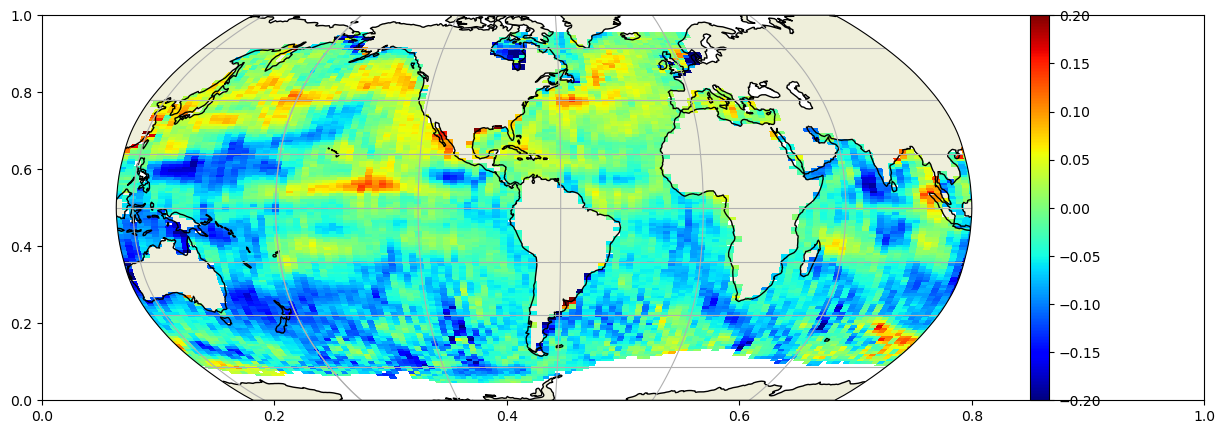

In [24]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(longrid,latgrid,grids_3x1.SSHA[1,:,:].squeeze(),transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)

In [25]:
diff=(grids_regrid-grids_3x1.SSHA)
diff

<xarray.DataArray 'SSHA' (time: 923, lat: 180, lon: 120)>
dask.array<subtract, shape=(923, 180, 120), dtype=float64, chunksize=(1, 180, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 165 168 171 174 177
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04

In [26]:
grids_regrid.shape

(923, 180, 120)

In [27]:
grids_regrid2 = xr.DataArray(grids_regrid, dims=['time','lat','lon'])
grids_regrid2 = grids_regrid2.assign_coords({'time':grids.time,'lon':longrid,'lat':latgrid})
grids_regrid2

<xarray.DataArray 'SSHA' (time: 923, lat: 180, lon: 120)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) int64 -180 -177 -174 -171 -168 -165 ... 165 168 171 174 177
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m

In [28]:
result = diff.polyfit(dim = "time", deg = 1, skipna=True)
trend_diff = result.polyfit_coefficients.sel(degree=1)*int(diff.time[-1]-diff.time[0])

result = (grids_regrid2).polyfit(dim = "time", deg = 1, skipna=True)
trend_grids_regrid = result.polyfit_coefficients.sel(degree=1)*int(diff.time[-1]-diff.time[0])

result = (grids.SSHA).polyfit(dim = "time", deg = 1, skipna=True)
trend_grids = result.polyfit_coefficients.sel(degree=1)*int(diff.time[-1]-diff.time[0])

result = (grids_3x1.SSHA).polyfit(dim = "time", deg = 1, skipna=True)
trend_grids_3x1 = result.polyfit_coefficients.sel(degree=1)*int(diff.time[-1]-diff.time[0])

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(diff.lon,diff.lat,trend_diff,transform=ccrs.PlateCarree(),vmin=-2,vmax=2, cmap='jet')
h=plt.colorbar(p)

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(diff.lon,diff.lat,trend_grids_3x1,transform=ccrs.PlateCarree(),vmin=-20,vmax=20, cmap='jet')
h=plt.colorbar(p)

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(diff.lon,diff.lat,trend_grids_regrid,transform=ccrs.PlateCarree(),vmin=-20,vmax=20, cmap='jet')
h=plt.colorbar(p)

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(grids_3x1.lon,grids_3x1.lat,trend_grids_3x1,transform=ccrs.PlateCarree(),vmin=-20,vmax=20, cmap='jet')
h=plt.colorbar(p)

### Compare alongtrack vs grids vs 3x1 grids

In [ ]:
f=9000
ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[f:f+10]
alongtrack = xr.open_mfdataset(
        paths=ECCO_alongtrack_files_cycle,
        combine='nested',
        concat_dim='i',
        decode_cf=True,
        compat='override',
        coords='minimal',
        chunks={'time': 1}  
    )  
alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
SSH_at_xy_ano=alongtrack.SSH_at_xy
ind=np.where(np.isfinite(SSH_at_xy_ano.values))
x=SSH_at_xy_ano.lon.values[ind]
y=SSH_at_xy_ano.lat.values[ind]
data=SSH_at_xy_ano.values[ind]

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.scatter(x,y,6,data,transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)

In [ ]:
ds = xr.open_dataset(str(output_dir) + '/SSHA_gridded_3x1_2017-05-19.nc')
ds

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(ds.lon,ds.lat,ds.SSHA,transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)

In [ ]:
ds = xr.open_dataset(str(Path('/home/jovyan/Data/ECCO_GMSL/gridding_output_3errors_2cm/')) + '/SSHA_gridded_2017-05-19.nc')
ds

In [ ]:
fig = plt.figure(figsize=(15,5))
cm = plt.get_cmap('gist_rainbow')
ax=fig.gca()

ax = plt.axes(projection=ccrs.Robinson(central_longitude=-67, globe=None))
ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

p=ax.pcolor(ds.longitude,ds.latitude,ds.SSHA,transform=ccrs.PlateCarree(),vmin=-0.2,vmax=0.2, cmap='jet')
h=plt.colorbar(p)